In [0]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [27]:
data = pd.read_csv('./creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


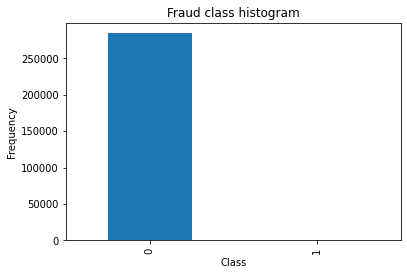

In [28]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
print(count_classes)

In [29]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [0]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [31]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/float(len(under_sample_data)))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/float(len(under_sample_data)))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [45]:
from sklearn.model_selection import train_test_split

# split whole dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions whole train dataset: ", len(X_train))
print("Number transactions whole test dataset: ", len(X_test))
print("Total number of whole transactions: ", len(X_train)+len(X_test))


# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions undersample train dataset: ", len(X_train_undersample))
print("Number transactions undersample test dataset: ", len(X_test_undersample))
print("Total number of undersample transactions: ", len(X_train_undersample)+len(X_test_undersample))
y_true_undersample, y_pred_undersample = y_test_undersample, clf.predict(X_test_undersample)

Number transactions whole train dataset:  199364
Number transactions whole test dataset:  85443
Total number of whole transactions:  284807

Number transactions undersample train dataset:  688
Number transactions undersample test dataset:  296
Total number of undersample transactions:  984


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [0]:
# Define a function to find the best hyper-parameter optimizing for recall
def print_gridsearch_scores(x_train_data,y_train_data, parameter_grid, parameter_col, model):
  
    clf = GridSearchCV(model, {parameter_col: parameter_grid}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data.values.ravel())

    print ("Best parameters set found on development set:")
    print()
    print (clf.best_params_)

    print ("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print ("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_[parameter_col]

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from itertools import cycle

def precision_recall_func(y_pred_undersample_proba):
  j = 1
  thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])
  plt.figure(figsize=(5,5))
  for i,color in zip(thresholds,colors):
      y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
      
      precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
      
      # Plot Precision-Recall curve
      plt.plot(recall, precision, color=color,
                  label='Threshold: %s'%i)
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.ylim([0.0, 1.05])
      plt.xlim([0.0, 1.0])
      plt.title('Precision-Recall example')
      plt.legend(loc="lower left")

In [0]:
def conf_matrix_on_pred(y_test,y_pred):
  cnf_matrix = confusion_matrix(y_test,y_pred)
  np.set_printoptions(precision=2)

  print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

  # Plot non-normalized confusion matrix
  class_names = [0,1]
  plt.figure()
  plot_confusion_matrix(cnf_matrix
                        , classes=class_names
                        , title='Confusion matrix')
  plt.show()

In [0]:
def conf_matrix_on_multiple_recall(y_pred):
  thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

  plt.figure(figsize=(10,10))

  j = 1
  for i in thresholds:
      y_test_predictions_high_recall = y_pred[:,1] > i
      
      plt.subplot(3,3,j)
      j += 1
      
      # Compute confusion matrix
      cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
      np.set_printoptions(precision=2)

      print ("Recall metric in the undersample testing dataset for threshold {}: {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

      # Plot non-normalized confusion matrix
      class_names = [0,1]
      plot_confusion_matrix(cnf_matrix
                            , classes=class_names
                            , title='Threshold >= %s'%i) 

**Knn**

In [58]:
n_neighbors = [1, 2, 3, 4, 5] 

print("Knn:")
print()

knn_model = KNeighborsClassifier()
best_n_neighbors_undersample = print_gridsearch_scores(X_train_undersample,y_train_undersample, n_neighbors,"n_neighbors", knn_model)

knn_undersample_model = KNeighborsClassifier(n_neighbors = best_n_neighbors_undersample)

Knn:

Best parameters set found on development set:

{'n_neighbors': 1}
Grid scores on development set:
0.910 (+/-0.046) for {'n_neighbors': 1}
0.878 (+/-0.043) for {'n_neighbors': 2}
0.890 (+/-0.030) for {'n_neighbors': 3}
0.875 (+/-0.039) for {'n_neighbors': 4}
0.890 (+/-0.039) for {'n_neighbors': 5}


Recall metric in the testing dataset:  0.9183673469387755


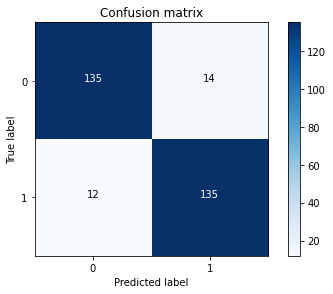

In [59]:
knn_undersample_model.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_test = knn_undersample_model.predict(X_test_undersample.values)
conf_matrix_on_pred(y_test_undersample, y_pred_undersample_test)

Recall metric in the testing dataset:  0.7891156462585034


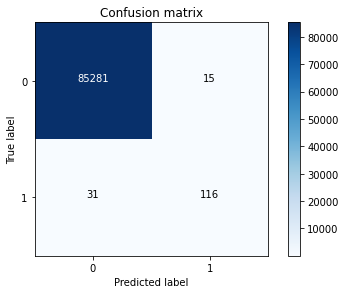

In [60]:
knn_undersample_model.fit(X_train,y_train.values.ravel())
y_pred_test = knn_undersample_model.predict(X_test.values)
conf_matrix_on_pred(y_test,y_pred_test)

Recall metric in the undersample testing dataset for threshold 0.1: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.2: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.3: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.4: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.5: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.6: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.7: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.8: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.9: 0.9115646258503401


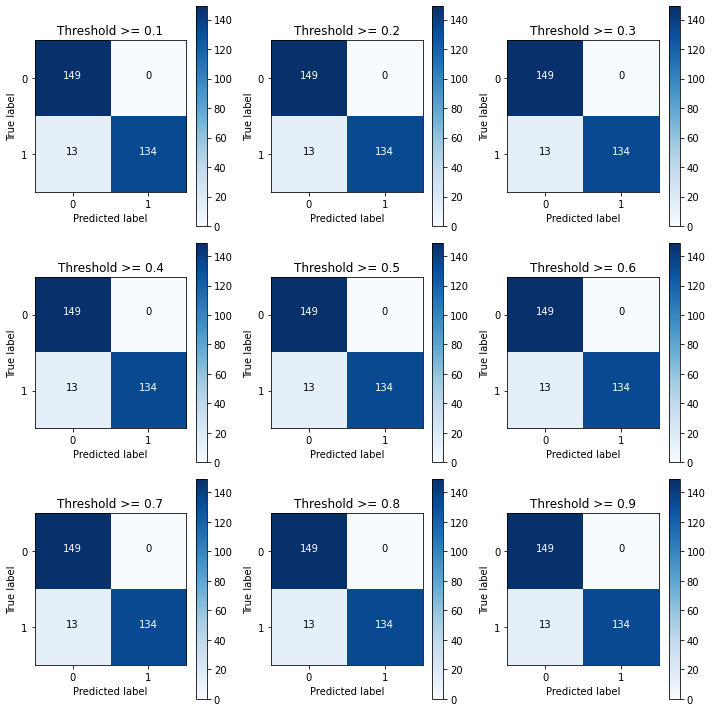

In [61]:
y_pred_undersample_proba = knn_undersample_model.predict_proba(X_test_undersample.values)
conf_matrix_on_multiple_recall(y_pred_undersample_proba)

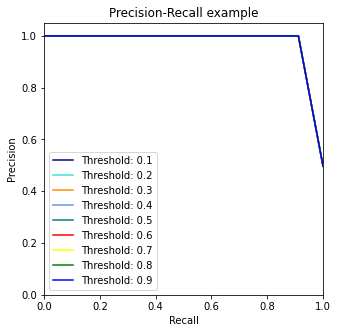

In [62]:
precision_recall_func(y_pred_undersample_proba)

**Random** **Forest**

In [70]:
n_estimators = [5, 10, 20, 50]

print("Random Forest:")
print()

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
best_n_estimators_undersample = print_gridsearch_scores(X_train_undersample,y_train_undersample, n_estimators,"n_estimators", rf_model)
rf_undersample_model = RandomForestClassifier(n_estimators=best_n_estimators_undersample, random_state=0)

Random Forest:

Best parameters set found on development set:

{'n_estimators': 5}
Grid scores on development set:
0.904 (+/-0.054) for {'n_estimators': 5}
0.893 (+/-0.054) for {'n_estimators': 10}
0.896 (+/-0.085) for {'n_estimators': 20}
0.893 (+/-0.085) for {'n_estimators': 50}


Recall metric in the testing dataset:  0.9251700680272109


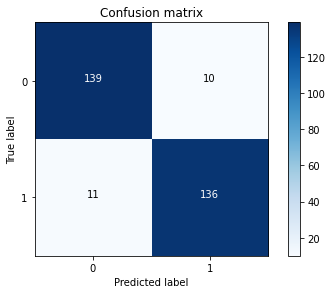

In [71]:
rf_undersample_model.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_test = rf_undersample_model.predict(X_test_undersample.values)
conf_matrix_on_pred(y_test_undersample, y_pred_undersample_test)

Recall metric in the testing dataset:  0.7482993197278912


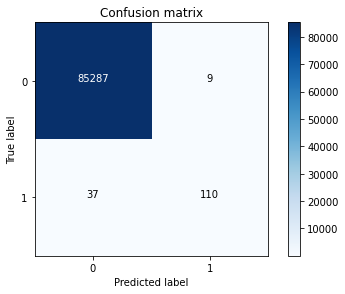

In [72]:
rf_undersample_model.fit(X_train,y_train.values.ravel())
y_pred_test = rf_undersample_model.predict(X_test.values)
conf_matrix_on_pred(y_test,y_pred_test)

Recall metric in the undersample testing dataset for threshold 0.1: 0.9251700680272109
Recall metric in the undersample testing dataset for threshold 0.2: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.3: 0.9115646258503401
Recall metric in the undersample testing dataset for threshold 0.4: 0.8639455782312925
Recall metric in the undersample testing dataset for threshold 0.5: 0.8639455782312925
Recall metric in the undersample testing dataset for threshold 0.6: 0.782312925170068
Recall metric in the undersample testing dataset for threshold 0.7: 0.782312925170068
Recall metric in the undersample testing dataset for threshold 0.8: 0.5918367346938775
Recall metric in the undersample testing dataset for threshold 0.9: 0.5918367346938775


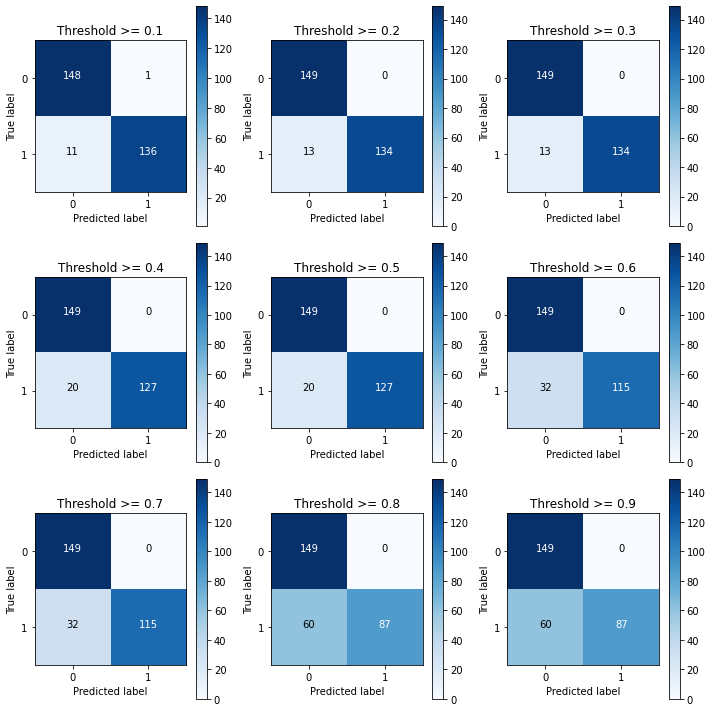

In [73]:
y_pred_undersample_proba = rf_undersample_model.predict_proba(X_test_undersample.values)
conf_matrix_on_multiple_recall(y_pred_undersample_proba)

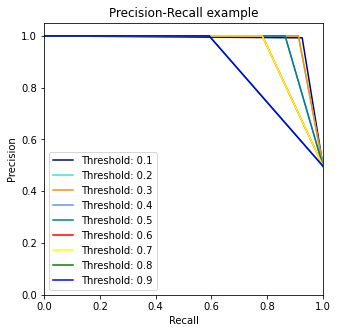

In [74]:
precision_recall_func(y_pred_undersample_proba)

**Decision Tree**

In [75]:
max_depth = [3, 4, 5, 6, 7]

print("DecisionTree:")
print()

from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
best_max_depth_undersample = print_gridsearch_scores(X_train_undersample,y_train_undersample, max_depth,"max_depth", dt_model)
dt_undersample_model = DecisionTreeClassifier(max_depth=best_max_depth_undersample, random_state=0)

DecisionTree:

Best parameters set found on development set:

{'max_depth': 7}
Grid scores on development set:
0.893 (+/-0.068) for {'max_depth': 3}
0.899 (+/-0.095) for {'max_depth': 4}
0.899 (+/-0.092) for {'max_depth': 5}
0.901 (+/-0.070) for {'max_depth': 6}
0.910 (+/-0.067) for {'max_depth': 7}


Recall metric in the testing dataset:  0.9183673469387755


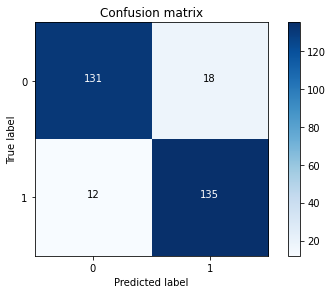

In [76]:
dt_undersample_model.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_test = dt_undersample_model.predict(X_test_undersample.values)
conf_matrix_on_pred(y_test_undersample, y_pred_undersample_test)

Recall metric in the testing dataset:  0.7482993197278912


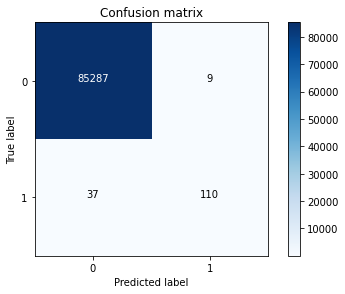

In [77]:
dt_undersample_model.fit(X_train,y_train.values.ravel())
y_pred_test = dt_undersample_model.predict(X_test.values)
conf_matrix_on_pred(y_test,y_pred_test)

Recall metric in the undersample testing dataset for threshold 0.1: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.2: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.3: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.4: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.5: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.6: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.7: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.8: 0.8027210884353742
Recall metric in the undersample testing dataset for threshold 0.9: 0.8027210884353742


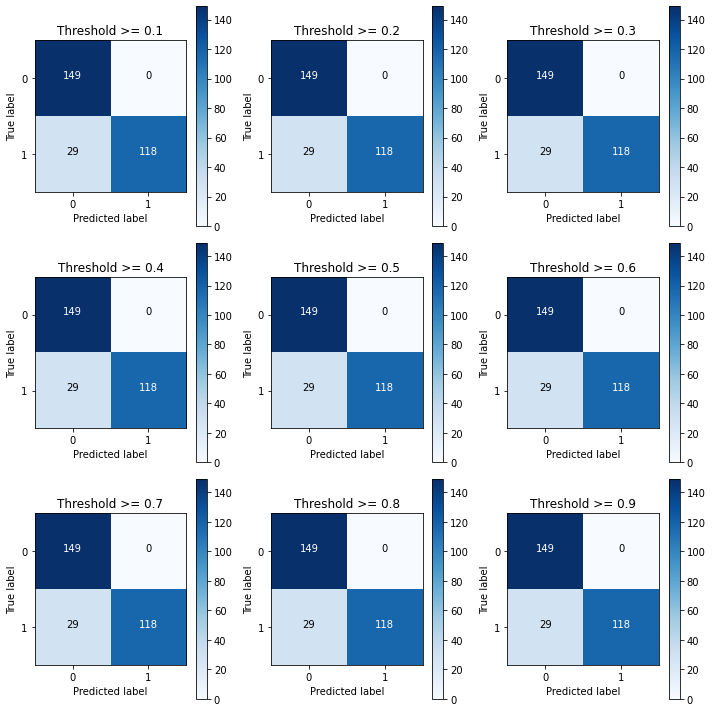

In [78]:
y_pred_undersample_proba = dt_undersample_model.predict_proba(X_test_undersample.values)
conf_matrix_on_multiple_recall(y_pred_undersample_proba)

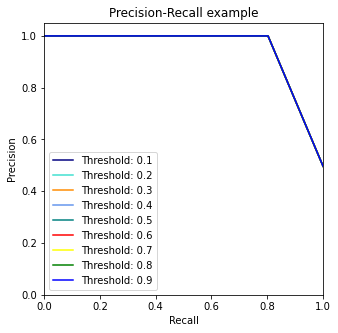

In [79]:
precision_recall_func(y_pred_undersample_proba)